## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore') 


%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 

## Import Data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
# Combined training and testing data together for data cleaning and processing
combine = pd.concat([train_data,test_data], keys=['train', 'test']).reset_index().drop('level_1',1).rename({'level_0':'Source'}, axis = 1)
combine.head(3)

,Source,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,train,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,train,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,train,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## EDA 
* Data cleaning - Null values, data format, data processing
* Data Exploration - Distribution, correlation
* Make assumptions!

In [4]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Source       1309 non-null   object 
 1   PassengerId  1309 non-null   int64  
 2   Survived     891 non-null    float64
 3   Pclass       1309 non-null   int64  
 4   Name         1309 non-null   object 
 5   Sex          1309 non-null   object 
 6   Age          1046 non-null   float64
 7   SibSp        1309 non-null   int64  
 8   Parch        1309 non-null   int64  
 9   Ticket       1309 non-null   object 
 10  Fare         1308 non-null   float64
 11  Cabin        295 non-null    object 
 12  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [5]:
combine[combine['Cabin'].notnull()].head(5)

,Source,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,train,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,train,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,train,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,train,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,train,12,1.0,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [6]:
combine.nunique()

Source            2
PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

In [7]:
combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [8]:
# Use describe on Sting type (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) 
combine.describe(include=['O'])

,Source,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,1309,295,1307
unique,2,1307,2,929,186,3
top,train,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,891,2,843,11,6,914


In [9]:
combine.columns

Index(['Source', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
combine_train = combine[combine['Source'] == 'train']

## Survived: Survival
* 0 = No, 1 = Yes
* Categorical
* The survival rate increase as Pclass 

In [11]:
combine['Survived'] = combine['Survived'].astype('Int64')

### Pclass: A proxy for socio-economic status (SES)
* Ticket class
* 1 = 1st(Upper), 2 = 2nd(Middle), 3 = 3rd(Lower)
* There are no missing value (From info function)
* Survival rate: 63% in P1, 47% in P2, 24% in P3

In [12]:
train_data.groupby('Pclass').agg(['mean', 'count'])

PassengerId        Survived              Age           SibSp        \
              mean count      mean count       mean count      mean count   
Pclass                                                                      
1       461.597222   216  0.629630   216  38.233441   186  0.416667   216   
2       445.956522   184  0.472826   184  29.877630   173  0.402174   184   
3       439.154786   491  0.242363   491  25.140620   355  0.615071   491   

           Parch             Fare        
            mean count       mean count  
Pclass                                   
1       0.356481   216  84.154687   216  
2       0.380435   184  20.662183   184  
3       0.393075   491  13.675550   491

## Sex
* No missing value 
* Need to change datatype
* Summary: 
    * Female has hight survival rate, but number of passengers are lesser compares to male
    * The distribution are similar for male and female
    * SibSp, Parch and Fare are higher in female than male

In [13]:
train_data.groupby('Sex').agg(['mean', 'count'])

PassengerId        Survived          Pclass              Age        \
              mean count      mean count      mean count       mean count   
Sex                                                                         
female  431.028662   314  0.742038   314  2.159236   314  27.915709   261   
male    454.147314   577  0.188908   577  2.389948   577  30.726645   453   

           SibSp           Parch             Fare        
            mean count      mean count       mean count  
Sex                                                      
female  0.694268   314  0.649682   314  44.479818   314  
male    0.429809   577  0.235702   577  25.523893   577

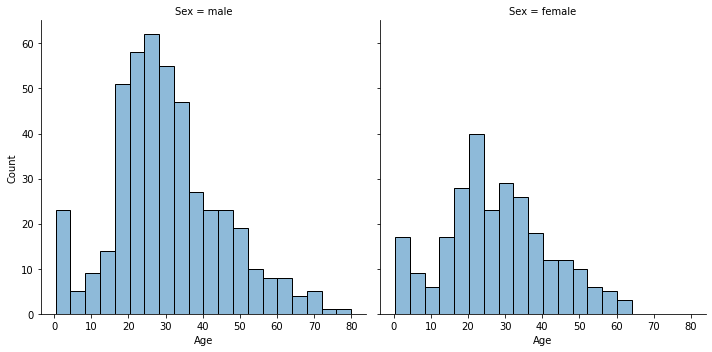

In [14]:
sns.displot(
        data = train_data,
        x = train_data['Age'],
        col = train_data['Sex'],
        alpha = 0.5
)

In [15]:
# combine['Sex'].replace(['male','female'],[0, 1], inplace = True)
combine['Sex'] = combine['Sex'].map({'female': 0, 'male': 1}).astype(int)
train_data['Sex'] = train_data['Sex'].map({'female': 0, 'male': 1}).astype(int)

## Age
* ~20% of null values

In [16]:
round(train_data['Age'].isnull().sum()/len(train_data['Age'])*100,2)

19.87

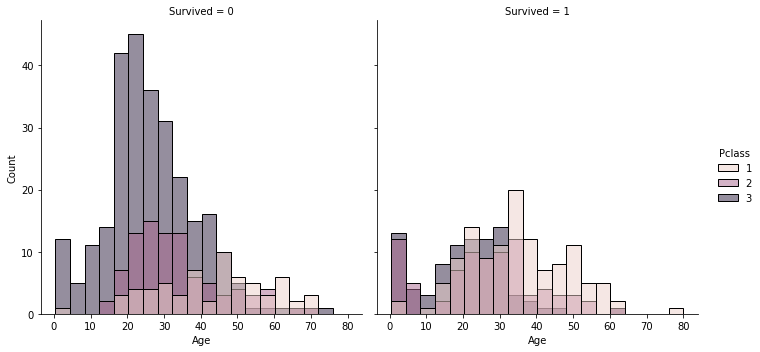

In [17]:
sns.displot(
        data = train_data,
        x = train_data['Age'],
        hue = train_data['Pclass'],
        col = train_data['Survived']
)

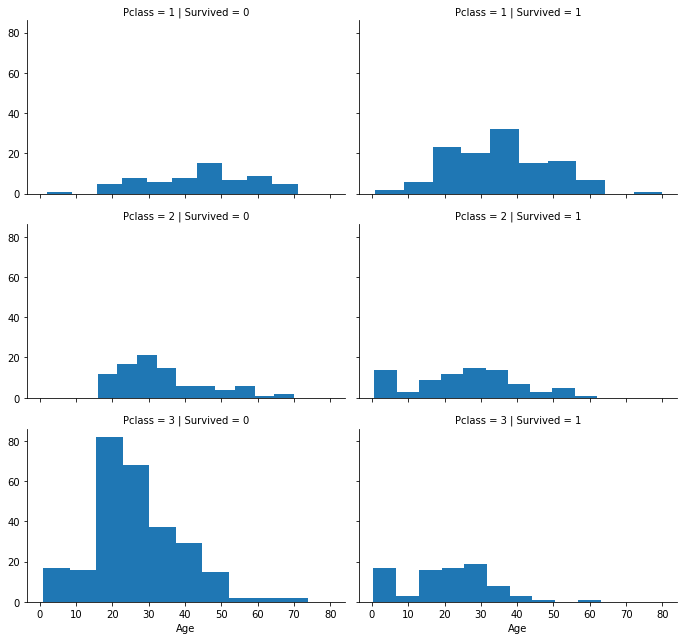

In [18]:
# Split view
g = sns.FacetGrid(train_data, col = 'Survived', row = 'Pclass', aspect = 1.6)
g.map(plt.hist, 'Age', bins = 10)

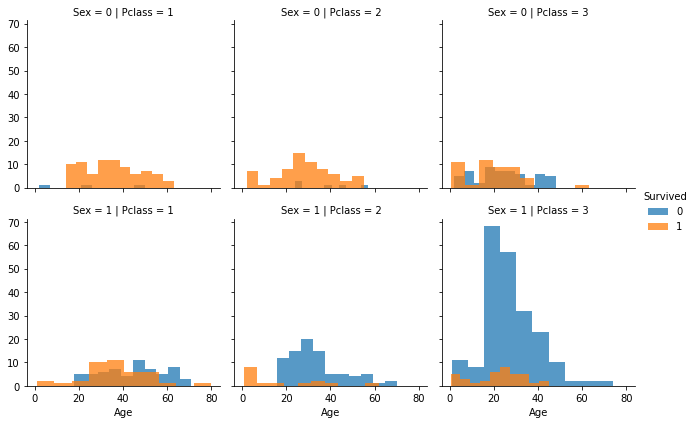

In [19]:
h = sns.FacetGrid(train_data, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

In [20]:
# Method1: Fill the null value by using random numbers between 68% and assume normal distribution
#for df in combine:
#    age_avg = df['Age'].mean()
#    age_std = df['Age'].std()
#    age_null_count = df['Age'].isnull().sum()
    
#    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
#    df['Age'][np.isnan(df['Age'])] = age_null_random_list
#    df['Age'] = df['Age'].astype(int)
    
#train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)


# Filling the missing values in Age with the medians of Sex and Pclass groups
combine['Age'] = combine.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())).astype('int')

In [21]:
combine['Age_Group'] = pd.cut(combine['Age'], 5)
round(combine[['Age_Group', 'Survived']].groupby(['Age_Group']).mean(),3)

,Survived
Age_Group,
"(-0.08, 16.0]",0.55
"(16.0, 32.0]",0.337
"(32.0, 48.0]",0.412
"(48.0, 64.0]",0.435
"(64.0, 80.0]",0.091


In [22]:
combine['Age_Group'] = combine['Age_Group'].astype('string')

combine['Age_Group'] = combine['Age_Group'].replace(
    {'(-0.08, 16.0]': 1, 
     '(16.0, 32.0]': 2, 
     '(32.0, 48.0]': 3, 
     '(48.0, 64.0]': 4,
    '(64.0, 80.0]': 5} ).astype(int)

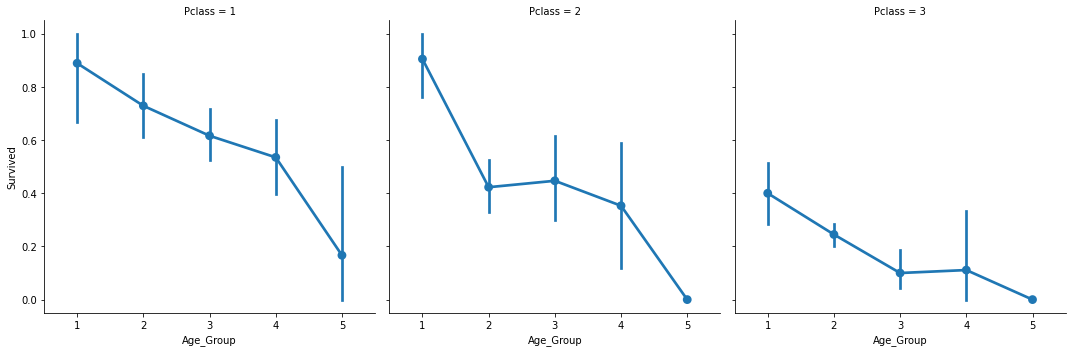

In [23]:
sns.factorplot('Age_Group','Survived',data = combine[combine['Source'] == 'train'], col = 'Pclass')
plt.show()

## Sibsp & Parch
* Sibsp: # of siblings / spouses aboard the Titanic
* parch: # of parents / children aboard the Titanic

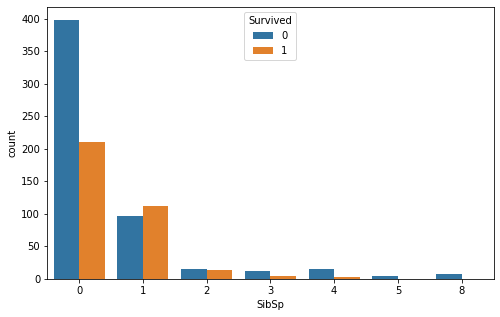

In [24]:
plt.figure(figsize = (8,5))
sns.countplot(x="SibSp", hue='Survived', data= train_data)
plt.show()

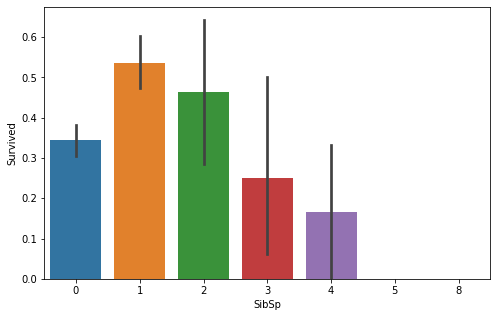

In [25]:
plt.figure(figsize = (8,5))
sns.barplot("SibSp", 'Survived', data= train_data)
plt.show()

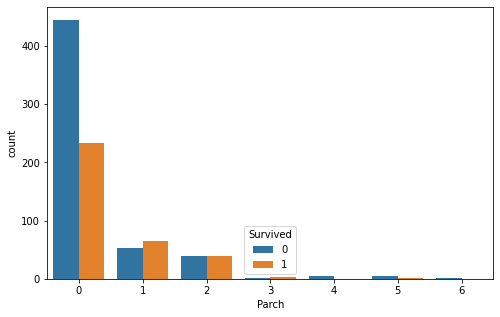

In [26]:
plt.figure(figsize = (8,5))
sns.countplot(x="Parch", hue='Survived', data= train_data)
plt.show()

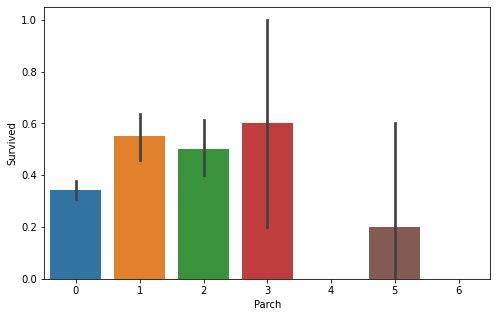

In [27]:
plt.figure(figsize = (8,5))
sns.barplot("Parch", 'Survived', data= train_data)
plt.show()

In [28]:
combine['Family_Size'] = combine['SibSp'] + combine['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
combine['Is_Alone'] = 0
combine.loc[combine['Family_Size'] == 1, 'Is_Alone'] = 1

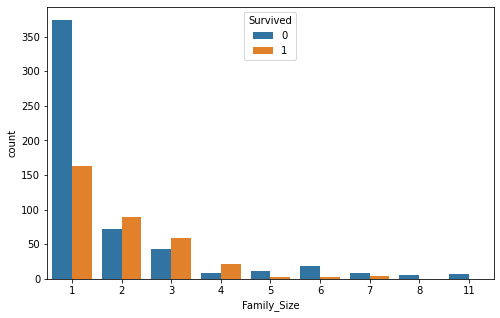

In [29]:
plt.figure(figsize = (8,5))
sns.countplot(x="Family_Size", hue='Survived', data= combine[combine['Source'] == 'train'])
plt.show()

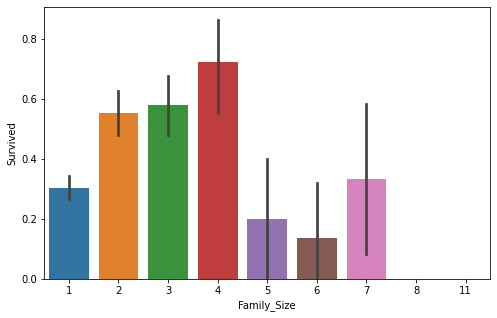

In [30]:
plt.figure(figsize = (8,5))
sns.barplot("Family_Size", 'Survived', data= combine[combine['Source'] == 'train'])
plt.show()

## Cabin: 
* 77.1% is null values

In [31]:
round(train_data['Cabin'].isnull().sum()/len(train_data['Cabin'])*100,2)

77.1

In [32]:
combine['Cabin'].str[0].value_counts(dropna = False)

NaN    1014
C        94
B        65
D        46
E        41
A        22
F        21
G         5
T         1
Name: Cabin, dtype: int64

In [33]:
# Question: Why Cabin_app can not show the entire value but 3...?
# g = sns.FacetGrid(combine[combine['Source'] == 'train'], col =["Pclass","Cabin_abb"], hue="Survived")
# g.map(sns.countplot, "Cabin_abb", alpha=.7, palette="Set3")
# plt.show()

## Embark: Port of Embarkation
* C = Cherbourg, Q = Queenstown, S = Southampton
* only two null value

In [34]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [35]:
# Pull the null values 
train_data[train_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN


In [36]:
# Check the frequency
train_data[['Embarked','Pclass']].value_counts()

Embarked  Pclass
S         3         353
          2         164
          1         127
C         1          85
Q         3          72
C         3          66
          2          17
Q         2           3
          1           2
dtype: int64

In [37]:
pd.DataFrame(combine[['Embarked', 'Pclass', 'Survived']].value_counts())

0
Embarked Pclass Survived     
S        3      0         286
         2      0          88
                1          76
         1      1          74
         3      1          67
C        1      1          59
S        1      0          53
Q        3      0          45
C        3      0          41
Q        3      1          27
C        1      0          26
         3      1          25
         2      1           9
                0           8
Q        2      1           2
                0           1
         1      1           1
                0           1

In [38]:
train_data[['Embarked', 'Survived']].groupby(['Embarked']).mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [39]:
# Fillna with the most frequent: Though C Embarked will have higher survival rate, but the frequncy is higher in 'S'
combine['Embarked'] = combine['Embarked'].fillna('S')

In [40]:
combine['Embarked'] = combine['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

## Fair: 

In [41]:
# Filling the missing values in Fare with the median of Sex and Pclass groups
combine['Fare'] = combine.groupby(['Sex', 'Pclass'])['Fare'].apply(lambda x: x.fillna(x.median())).astype('float')

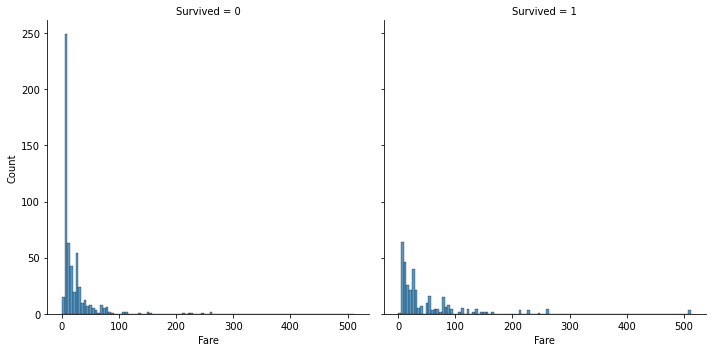

In [42]:
sns.displot(
        data = train_data,
        x = train_data['Fare'],
        col = train_data['Survived']
)

In [43]:
combine['Fare_Group'] = pd.cut(combine['Fare'], 4, labels = [1, 2, 3, 4])
round(combine[['Fare_Group', 'Survived']].groupby(['Fare_Group']).mean(),3)

,Survived
Fare_Group,
1,0.368
2,0.724
3,0.667
4,1.0


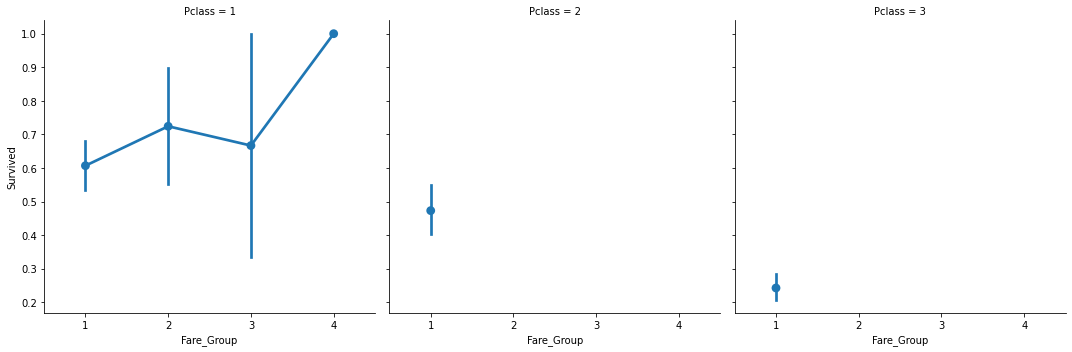

In [44]:
sns.factorplot('Fare_Group','Survived',data = combine[combine['Source'] == 'train'], col = 'Pclass')
plt.show()

## Title: 
* Title can be indicate age and sex. From the previous exploratory analysis, we know female has higher survival rate, so as yound kids.  
* Use this to make the info more informative

In [45]:
combine['Title'] = combine.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(combine['Title'], combine['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [46]:
combine['Title'] = combine['Title'].replace(['Capt','Col','Countess','Don','Dona', 'Dr','Lady', 'Major','Jonkheer', 'Rev', 'Sir'], 'Other')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

combine_train = combine[combine['Source'] == 'train']
combine_train[['Title', 'Survived']].groupby(['Title']).mean().sort_values(by= 'Survived', ascending = False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575
Other,0.347826
Mr,0.156673


In [47]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}

combine['Title'] = combine['Title'].map(title_mapping)
combine['Title'] = combine['Title'].fillna(0)

combine_train['Title'] = combine_train['Title'].map(title_mapping)
combine_train['Title'] = combine_train['Title'].fillna(0)

## Correlation matrix

<AxesSubplot:>

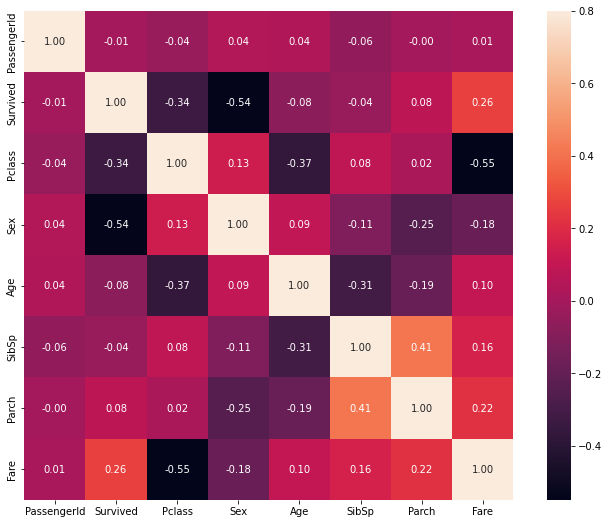

In [48]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, 
            cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10})

## Create the final dataset

In [49]:
from sklearn.model_selection import train_test_split

combine_train = combine[combine['Source'] == 'train']
combine_test = combine[combine['Source'] == 'test']

# features = ['Pclass', 'Sex', 'Fare','Embarked', 'Age_Group','Family_Size', 'Is_Alone', 'Fare_Group', 'Title']
features = ['Pclass','Sex','Title','Fare', 'Age','Embarked', 'Is_Alone','Family_Size']
predictors = combine_train[features]
target = combine_train['Survived'].astype('int')
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 0)

In [50]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

81.01


In [51]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='sag')
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

73.74


In [52]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

72.63


In [53]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

81.01


In [54]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

81.01


In [55]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

83.24


In [56]:
# Random forest

from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)


86.03


In [57]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

77.09


In [58]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

82.68


In [59]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

84.92


## Submission code

In [60]:
X_test = combine_test[features]
predictions = gbk.predict(X_test)

output = pd.DataFrame({'PassengerID': combine_test['PassengerId'], 'Survived': predictions})
output.to_csv('submission.csv', index = False)
print("Your submission was successfuly saved!")

Your submission was successfuly saved!


### Reference:
1. NoteBooks:
    * [11 algos titanic prediction ,EDA, visualization](https://www.kaggle.com/gaganmaahi224/11-algos-titanic-prediction-eda-visualization#EDA-of-train-dataset)
    * [How am I doing with my score?](https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score)
    * [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#1.-So...-What-can-we-expect?)
    * [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)    
    * [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)  
    * [Titanic Survival Predictions (Beginner)](https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner)     
    
2. Reference:
    * qcut: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html     
    * Convert to int issue: http://net-informations.com/ds/err/nan.htm